In [2]:
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 81.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavio

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub # Tensorflow bert 社群
import tensorflow_text as text # 前處理
from official.nlp import optimization  # 優化工具
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're us

In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                  untar=True, cache_dir='.',
                  cache_subdir='')

# 整合資料路徑，方便之後模型讀取
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 19s 0us/step


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.


In [6]:
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1" # 這是預訓練模型
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3" # 這是 BERT 前處理需要用的模型

In [7]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess) # 呼叫前處理模型
text_test = ['this is such an amazing movie!'] # 先輸入簡單的句子看看會變成什麼樣子
text_preprocessed = bert_preprocess_model(text_test)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_results = bert_model(text_preprocessed)
print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262903  0.9928099  -0.1861187   0.3667383   0.15233696  0.65504414
  0.9681154  -0.9486272   0.00216167 -0.9877732   0.06842678 -0.9763059 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946355  0.34321314  0.3323151  ...  0.2130079   0.7102079
  -0.05771136]
 [-0.28742105  0.31981066 -0.2301857  ...  0.58455014 -0.21329743
   0.7269204 ]
 [-0.6615694   0.6887674  -0.8743296  ...  0.10877217 -0.26173162
   0.4785526 ]
 ...
 [-0.22561109 -0.28925592 -0.07064441 ...  0.4756602   0.83277166
   0.40025324]
 [-0.29824194 -0.2747312  -0.05450527 ...  0.48849782  1.0955361
   0.18163359]
 [-0.4437828   0.00930762  0.07223727 ...  0.17290081  1.1833241
   0.07897999]]


In [9]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 1
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                      num_train_steps=num_train_steps,
                      num_warmup_steps=num_warmup_steps,
                      optimizer_type='adamw')

In [ ]:
bert_encoder_model = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
num_classes = 2

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = bert_preprocess_model(text_input)
    encoder_outputs = bert_encoder_model(preprocessing_layer)
    net = encoder_outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

classifier_model.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

classifier_model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')

history = classifier_model.fit(x=train_ds,validation_data=val_ds,epochs=epochs)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [17]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 2159s 3s/step - loss: 0.3517 - accuracy: 0.8448
Loss: 0.35170212388038635
Accuracy: 0.8447999954223633


In [31]:
test_ds100 = test_ds.take(100)

predicted_sentiments = classifier_model.predict(test_ds100)
predicted_probabilities = tf.nn.softmax(predicted_sentiments).numpy()
positive_probabilities = predicted_probabilities[:, 1]

top_5_idx = np.argsort(positive_probabilities)[-5:][::-1]
bottom_5_idx = np.argsort(positive_probabilities)[:5]


text_reviews = []
for text_batch, _ in test_ds100:
    text_reviews.extend(text_batch.numpy())

top_5_reviews = [text_reviews[idx] for idx in top_5_idx]
bottom_5_reviews = [text_reviews[idx] for idx in bottom_5_idx]

print("Most Positive Reviews:")
for review in top_5_reviews:
    print(review)
print("Most Negative Reviews:")
for review in bottom_5_reviews:
    print(review)



Most Positive Reviews:
b"The Claude Lelouch's movie is a pretty good moment of cinema. One of the most touching films about family and loneliness, and surely the best interpretation of French actor Jean-Paul Belmondo."
b'"Here On Earth" is a surprising beautiful romantic tale about Samantha who has both boy problems and health problems. As her love for her current boyfriend, Jasper, fades away, her love for Kelley blooms like a new spring flower. <br /><br />I found this movie very touching, very warm, very romantic, and touching. I enjoyed every bit of this movie...and that\'s pretty rare! I highly do recommend this movie to all movie lovers! This is one film you don\'t want to miss!!! :D<br /><br />By the way...if you\'re a very sentimental person who easily cries while watching movies, BRING TISSUES!!! On the other hand, it was a really really good movie!!! Very romantic...and surprisingly good!!! :D<br /><br />'
b"But perhaps you have to have grown up in the 80's to truly appreciat

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

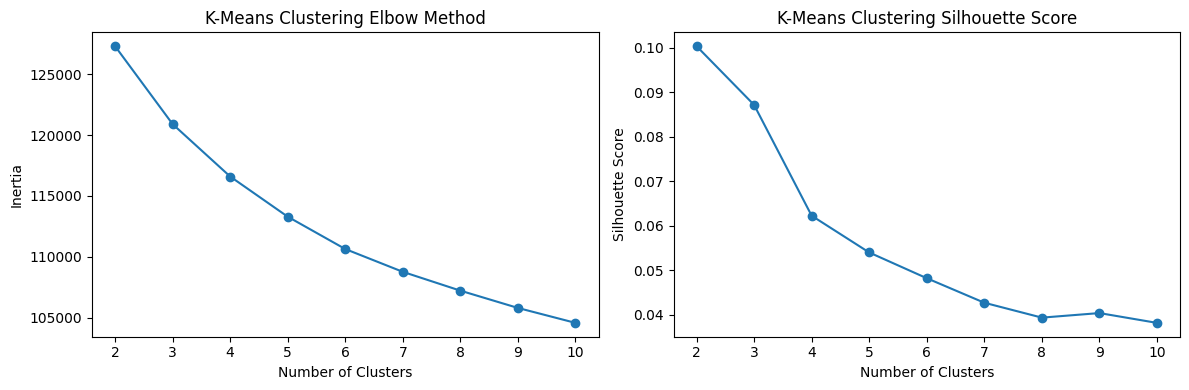

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


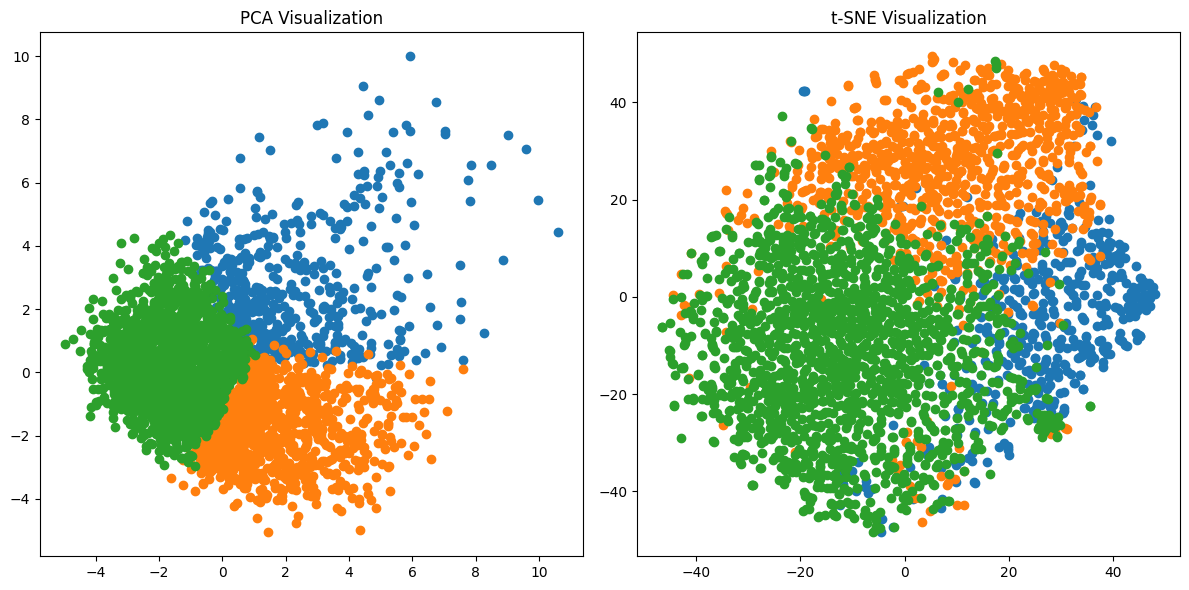

In [35]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics

test_ds100 = test_ds.take(100)
# Extract embeddings from BERT model
embeddings = []
for text_batch, _ in test_ds100:
    text_preprocessed = bert_preprocess_model(text_batch)
    result = bert_model(text_preprocessed)
    embeddings.append(result['pooled_output'])
embeddings = np.concatenate(embeddings, axis=0)

def silhouette_score(embeddings, labels):
    return metrics.silhouette_score(embeddings, labels, metric='euclidean')

# Apply K-Means Clustering
inertia = []
silhouette = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(embeddings, kmeans.labels_))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-Means Clustering Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('K-Means Clustering Silhouette Score')

plt.tight_layout()
plt.show()

# Visualize Clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
pca = PCA(n_components=2).fit_transform(embeddings)
tsne = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(k):
    cluster = pca[kmeans.labels_ == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i + 1}')
plt.title('PCA Visualization')

plt.subplot(1, 2, 2)
for i in range(k):
    cluster = tsne[kmeans.labels_ == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i + 1}')
plt.title('t-SNE Visualization')

plt.tight_layout()

plt.show()
